# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Ames housing dataset 
data = pd.read_csv('ames.csv')

# Print the dimensions of data
print(data.size)

# Check out the info for the dataframe
print(data.info())

# Show the first 5 rows
data.head()

118260
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  O

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [2]:
# Features and target data
target = data['SalePrice']
features = data[['LotArea', '1stFlrSF', 'GrLivArea']]

## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

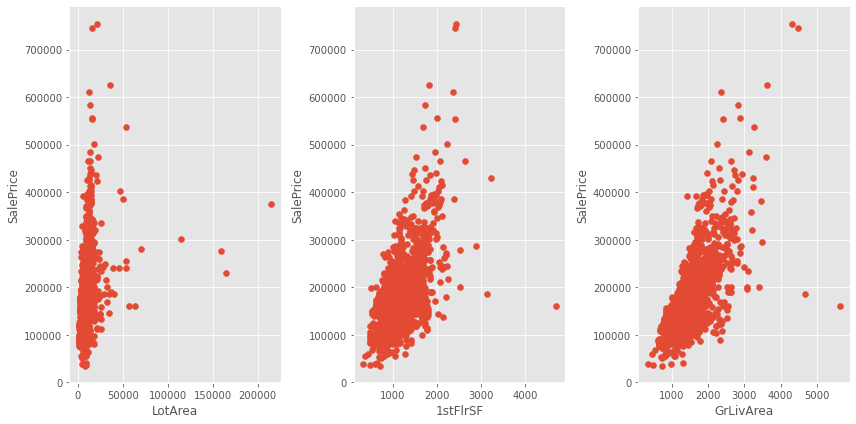

In [3]:
# Your code here 
fig, axs = plt.subplots(1, 3, figsize=(12,6))

for i, ax in enumerate(axs):
    ax.scatter(features.iloc[:,i], target)
    ax.set_xlabel(features.columns[i])
    ax.set_ylabel('SalePrice')
    
plt.tight_layout()

    All 3 scatter plots sow some linear relationship, but they also show outliers in particular on the x axis.  Those should probably be removed.
   

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [4]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    
    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)
    
    # Return the score
    return r2, rmse


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.6870225614927066]

(0.9228556485355649, 0.6870225614927066)

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [5]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size = 0.2, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [6]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.5961521990414137, 55656.48543887347)

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

In [7]:
# Your code here 
class Results:
    def __init__(self):
        self.train_r2s = []
        self.train_rmses = []
        self.test_r2s = []
        self.test_rmses = []

In [12]:
def test_param(param, values):
    results = Results()
    for value in values:
        dt = eval(f'DecisionTreeRegressor(random_state=45, {param} = {value})')
        dt.fit(X_train, y_train)
        
        # testing score
        
        y_pred = dt.predict(X_test)

        r2, rmse = performance(y_test, y_pred)
        
        results.test_r2s.append(r2)
        results.test_rmses.append(rmse)
        
        # training score
        
        y_pred = dt.predict(X_train)

        r2, rmse = performance(y_train, y_pred)
        
        results.train_r2s.append(r2)
        results.train_rmses.append(rmse)

        
    # plot results
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
    ax1.plot(values, results.test_r2s, label='Test')
    ax1.plot(values, results.train_r2s, label='Train')
    ax1.set_xlabel(param)
    ax1.set_ylabel('r2')
    ax1.legend()
    
    ax2.plot(values, results.test_rmses, label='Test')
    ax2.plot(values, results.train_rmses, label='Train')
    ax2.set_xlabel(param)
    ax2.set_ylabel('rmse')
    ax2.legend()
    
    df = pd.DataFrame([results.test_r2s, results.train_r2s, 
                       results.test_rmses, results.train_rmses]).T
    df.columns = ['test_r2s', 'train_r2s', 'test_rmses', 'train_rmses']
    display(df)
    # return
    return results

,test_r2s,train_r2s,test_rmses,train_rmses
0,0.320452,0.328705,72196.652118,63276.962053
1,0.446078,0.475609,65182.556011,55926.335283
2,0.537412,0.572557,59566.761604,50492.647555
3,0.575250,0.631129,57078.630088,46905.750013
4,0.629055,0.687694,53341.074169,43159.765758
5,0.647296,0.740904,52013.001813,39311.485909
6,0.659672,0.789560,51092.315365,35428.496867
7,0.662176,0.827571,50904.046690,32069.677704
8,0.636505,0.866708,52802.703428,28196.268422
9,0.634003,0.896321,52984.081288,24867.628986


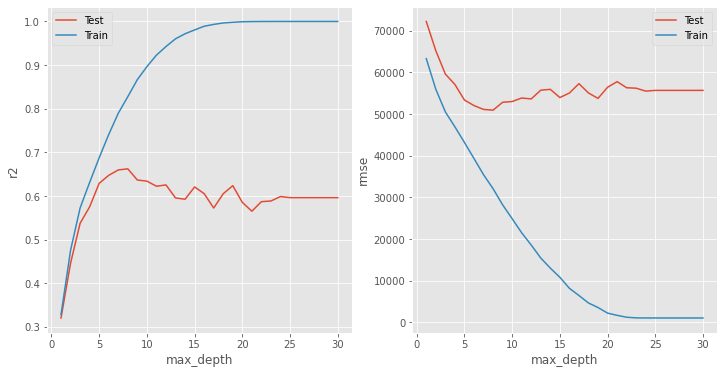

In [13]:
test_param('max_depth', np.arange(1, 31))

In [14]:
'''peak r2 and min rmse is at max_depth 7'''

'peak r2 and min rmse is at max_Depth 7'

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

,test_r2s,train_r2s,test_rmses,train_rmses
0,0.596152,0.999821,55656.485439,1034.200605
1,0.603204,0.982767,55168.400896,10138.305461
2,0.618347,0.968952,54105.490427,13608.351396
3,0.661020,0.952608,50991.019258,16812.773009
4,0.659288,0.940519,51121.151616,18835.473358
5,0.651800,0.916542,51679.852443,22311.194907
6,0.653441,0.903953,51557.921261,23934.880471
7,0.657531,0.894759,51252.774433,25054.280324
8,0.673464,0.884160,50046.335147,26285.658213
9,0.676198,0.873742,49836.424164,27442.197604


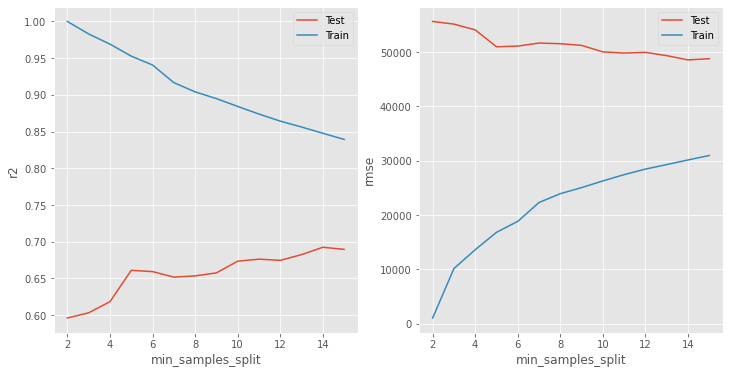

In [15]:
# Your code here 
test_param('min_samples_split', np.arange(2,16))

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [22]:
# Your code here 

clf = DecisionTreeRegressor(random_state=45, max_depth = 7, min_samples_split = 5)
clf.fit(X_train, y_train)

# testing score

y_pred = clf.predict(X_test)

test_r2, test_rmse = performance(y_test, y_pred)

# training score

y_pred = clf.predict(X_train)

train_r2, train_rmse = performance(y_train, y_pred)

test_r2, train_r2, test_rmse, train_rmse

(0.6721318710553857, 0.7843476243069895, 50148.33498676983, 35864.59897082576)

The test $R^2$ is not quite as high as the $R^2$ with only setting the min_sample_size.  I hope there is a better way to do this. 

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 

In [ ]:
# Your code here 

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Ames Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 